# Equilibrium examples
## Inverse Solve and Forward Solve for Grad-Shafranov Equilibria
This example notebook shows how to use FreeGSNKE to solve static Grad-Shafranov (GS) problems. Examples are provided for both inverse and forward solve modes. 
By forward solve mode, we refer to the case in which the coil currents are fixed by the user as inputs of the problem. Together with the profile parameterization the coild currents are used to obtain the GS equilibrium. 
By inverse solve mode, we refer to the case in which a set of coil currents are seeked so that the plasma is in some user-defined configuration. 
Below, we illustrate the mode aboves for plasmas in both diverted and limited configurations. 

The profiles chosen for this notebook follow the notation of Jeon (2015) for the toroidal plasma current:
$$j_{pl}=\lambda \left( 1-\psi_{n}^{\alpha_m} \right)^{\alpha_n}\left( \beta_{0}R/R_{0}+(1-\beta_{0}) R_{0}/R \right) $$ 
The first contribution is the pressure support $p'$, the second one is the toroidal-field support $f'f$.
More details are provided below.

__NB__ In this notebook, the necessary imports are made as soon as they are needed, to illustrate what they are responsible for, so you will find some "import" statements in cells further down.

In [1]:
import freegs
import matplotlib.pyplot as plt

## Create the machine object.

First, identify the files containing the machine description. FreeGSNKE requires the user to define the following environment variables:

ACTIVE_COILS_PATH , PASSIVE_COILS_PATH , WALL_PATH , LIMITER_PATH . These define the machine geometry and properties. 

The structure of the files containing the machine description is described in the notebook example_0 - machine_config. 

FreeGSNKE uses some of the base functionality provided by FreeGS to build "tokamak' machine objects, and the FreeGS public repository has some additional examples. 

The machine description used in this example is a simplified version of MAST-U.

In [2]:
import os
os.environ["ACTIVE_COILS_PATH"] = "../machine_configs/MAST-U/active_coils.pickle"
os.environ["PASSIVE_COILS_PATH"] = "../machine_configs/MAST-U/passive_coils.pickle"
os.environ["WALL_PATH"] = "../machine_configs/MAST-U/wall.pickle"
os.environ["LIMITER_PATH"] = "../machine_configs/MAST-U/limiter.pickle"

# Now the machine can actually be built:
from freegsnke import build_machine
tokamak = build_machine.tokamak()

## Instantiate an equilibrium

We are now ready to build a plasma equilibrium in the tokamak object. This is done using the `freegs.Equilibrium` class, which implicitly defines the rectangular domain of the solver as well as the grid resolution.

`Equilibrium` has sensible defaults, but it is recommended to define the radial and vertical domain of the grid using the `Rmin`, `Rmax`, `Zmin` and `Zmax` parameters, as well as the grid resolution in the radial and vertical directions with the `nx` and `ny` parameters.

A tokamak object should be supplied to the `tokamak` parameter to assign the desired machine to the equilibrium.

If available, an initial plasma flux function can be provided to the `psi` parameter (commented out in the following code).

In [3]:
eq = freegs.Equilibrium(
    tokamak=tokamak,
    Rmin=0.1, Rmax=2.0,   # Radial range
    Zmin=-2.2, Zmax=2.2,  # Vertical range
    nx=65,   # Number of grid points in the radial direction
    ny=129,  # Number of grid points in the vertical direction
    # psi=plasma_psi
)  

## Instantiate a profile object

A profile object can now be instantiated, which sets the parameterisation and properties of the profile function.
The profile object sets the value of the total plasma current.

FreeGSNKE accepts the same profile classes available in FreeGS: `ConstrainPaxisIp` or `ConstrainBetapIp`.
In the first case, the user defines the value of the plasma pressure at the magnetic axis, $p_a$. In the second case, the value of $\beta_p$, a proxy of the poloidal beta of the plasma is set.

The following example uses the `ConstrainPaxisIp` function, and an example demonstrating use of the `ConstrainBetapIp` function is in the following text cell.

Equilibrium (`eq`) and limiter (`tokamak.limiter`) objects are passed to the profile to inform calculations relating to the limiter.

The following parameters set the value for the profile properties.
- `paxis`: plasma pressure on axis [Pascals].
- `Ip`: total plasma current [Amps].
- `fvac`: vacuum toroidal field strength f = R * Bt.

The `alpha_m` and `alpha_n` coefficients define the 'peakedness' of the plasma current density distribution. See [this paper](https://arxiv.org/abs/1503.03135) for example.

In [4]:
from freegsnke.jtor_update import ConstrainPaxisIp

profiles = ConstrainPaxisIp(
    eq=eq,
    limiter=tokamak.limiter,
    paxis=8.1e3,
    Ip=6.2e5,
    fvac=0.5,
    alpha_m=1.8,
    alpha_n=1.2
)

As promised, here is an example of using `ConstrainBetapIp` instead. The call signature is nearly identical, except the poloidal beta (`betap`) is used instead. 'betap' is a pure number.

```python
from freegsnke.jtor_update import ConstrainBetapIp
profiles = ConstrainBetapIp(
    eq=eq,
    limiter=tokamak.limiter,
    betap=0.2,
    Ip=6.2e5,
    fvac=0.5,
    alpha_m=1.8,
    alpha_n=1.2
)
```

## Load the static nonlinear solver

We can now load FreeGSNKE's Grad-Shafranov static solver. The equilibrium is used to inform the solver of computational domain and tokamak properties.
The solver below can be used for both inverse and forward solve modes, as exemplified below.

__NB__ It is not necessary to instantiate a new solver to use it on new or different equilibria as long as the integration domain and the mesh are not changed. 

In [5]:
from freegsnke import GSstaticsolver
GSStaticSolver = GSstaticsolver.NKGSsolver(eq)    

## 1. Inverse solve

We start with an _inverse_ solve. In an inverse solve, we use a 'constrain' object, which sets the desired magnetic constraints. 
FreeGSNKE uses FreeGS' 'constrain' object, which accepts both constraints on the location of the X-points ('xpoints') and constraints on the geometry of the last closed closed flux surface ('isoflux').
In an inverse solve, the desired magnetic configuration described by the constrain object is used to seek a suitable set of coil currents. Both coil currents and the total flux $\psi(R,Z)$ are _outputs_.

Here, we specify a few constraints on the X-point position(s) and on some _isoflux_ points where $\psi(R,Z)$ should be the same.
This is identical to the FreeGS syntax, and we pass the instantiated equilibrium above the FreeGS 'constrain' object.

In [6]:
# Set X-point coordinates
Rx = 0.6
Zx = 1.1
xpoints = [(Rx, -Zx),   
           (Rx,  Zx)]

# Desired isoflux constraints,
# with structure (R1, Z1, R2, Z2)
# where (R1, Z1) and (R2, Z2) are 
# desired to be on the same flux contour.
Rmid = 1.41   # Outboard midplane
Rin = 0.35    # Inboard midplane
isoflux = [(Rx,Zx, Rx,-Zx), # link X-points
           (Rmid, 0, Rin, 0.0), # link inner and outer midplane points
           (Rmid, 0, Rx, Zx), # link outer midplane point and X-point

        #   some additional constraints
           (Rmid,0, 1.2,.7),
           (Rmid,0, 1.2,-.7),
           (Rx, Zx, .85, 1.7),
           (Rx, Zx, .75, 1.6),
           (Rx, Zx, Rin, 0.2),
           (Rx, Zx, Rin, 0.1),
           (Rx,-Zx, Rin, -0.1),
           (Rx,-Zx, Rin, -0.2),
           (Rx,-Zx, .85, -1.7),
           (Rx,-Zx, .75, -1.6),

           (Rx,-Zx, 0.45, -1.8),
           (Rx, Zx, 0.45,  1.8),
           ]
           

constrain = freegs.control.constrain(xpoints=xpoints, 
                                     isoflux=isoflux,
                                     gamma=5e-7
                                    )

Since the problem is often underconstrained, we also specify the quadratic regularization parameter "gamma". Higher values of gamma encourage lower absolute coil current values. It is sometimes useful to experiment with different values of gamma to explore whether the converged solution departs from the desired constraints. 

Coil current values can be accessed using 
```python 
eq.tokamak['coil name'].current
```
For example, 
```python 
eq.tokamak['P6'].current
```
should return that the current in coil 'P6' is zero, as no currents have been assigned to the object eq.tokamak after this was initialised.

It is also possible to fix specific coil current values for individual coils, and toggle control off for them. 
This means that the inverse solve procedure will not be allowed to vary those current values.
For example, in the following we are fixing the 'Solenoid' current to 5000 Amp and also requiring this value to stay fixed for the inverse solve.

In [7]:
eq.tokamak['Solenoid'].current = 5000
eq.tokamak['Solenoid'].control = False

(For instance, passive coils are automatically toggled off in during an inverse solve)

The following is the 'solve' call itself. Since a constrain object is provided, this is interpreted as an _inverse_ call and executed as such.
The 'target_relative_tolerance' is the maximum relative error allowed for convergence. 

In [8]:
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=constrain, 
                     target_relative_tolerance=1e-3)

The following shows how to display the resulting equilibrium, together with the imposed constraints.

<AxesSubplot:xlabel='Major radius [m]', ylabel='Height [m]'>

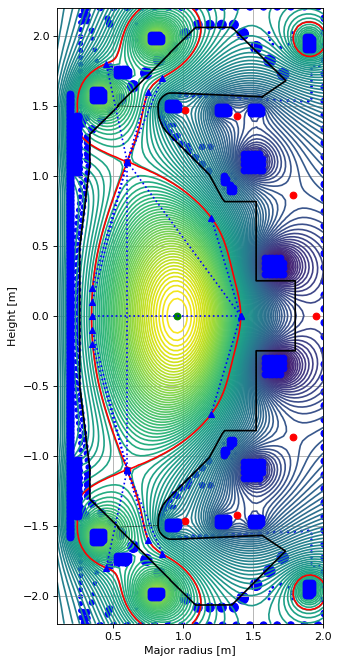

In [9]:
fig = plt.figure(figsize=(5, 10), dpi=80);
ax = fig.add_subplot(111);
ax.grid(True,which='both');
eq.plot(axis=ax,show=False);
eq.tokamak.plot(axis=ax,show=False);
constrain.plot(axis=ax,show=False)

A solve call modifies the equilibrium object in place. 
The total flux can be retrieved using 
```python
eq.psi()
```
while
```python
eq.plasma_psi
```
is the contribution of the plasma alone.
The plasma current can be retrieved with 
```python
profiles.jtor
```

The set of optimised coil currents can be retrieved using
```python
eq.tokamak.getCurrents()
```
These are now assigned to the equilibrium. 
The following saves these values for future use. 

In [10]:
inverse_current_values = eq.tokamak.getCurrents()

### 2. Forward solve

Here we'll use some fixed coil current values as inputs, and solve for the corresponding equilibrium. 
The syntax of a _forward_ solve is identical to that of an inverse call, but we set 
```python
constrain=None
```
As an example, we can use the set of currents identified in the inverse solve above.
Below we instantiate a new equilibrium and assign the current values. 

In [11]:
eq_forward = freegs.Equilibrium(
    tokamak=tokamak,
    Rmin=0.1, Rmax=2.0,   # Radial range
    Zmin=-2.2, Zmax=2.2,  # Vertical range
    nx=65,   # Number of grid points in the radial direction
    ny=129,  # Number of grid points in the vertical direction
    # psi=plasma_psi
)  

for key in inverse_current_values.keys():
    eq_forward.tokamak[key].current = inverse_current_values[key]

Since constrain=None in the following call of the static nonlinear solver, coil current values are not changed. The solver uses them as inputs to calculate the appropriate flux function.
This uses a Newton-Krylov implementation, described by Amorisco et al (2024) in _Physics of Plasmas_, which allows considerably more restrictive tolerance requests when compared to inverse solves. 

In [12]:
GSStaticSolver.solve(eq=eq_forward, 
                     profiles=profiles, 
                     constrain=None, 
                     target_relative_tolerance=1e-9)

In practice, with the above, we have improved on the equilibrium created in the inverse solve. 
Since it is often difficult to achieve low relative tolerances in _inverse_ solve calls (for example, the above was set at a loose target_relative_tolerance=1e-3), the above strategy of using a forward solve after an inverse one is useful to obtain better equilibria.
We remark that the second forward call uses the coil current values obtained by the inverse solve above as inputs, to output a better flux function. 
In the forward call coil currents are not modified. 

As additional example, below we manually vary some of the coil currents, perform new forward solves and compare the resulting equilibria.
Note that the manual current changes have caused the one of the equilibria to transition to a limiter configuration.

<AxesSubplot:xlabel='Major radius [m]', ylabel='Height [m]'>

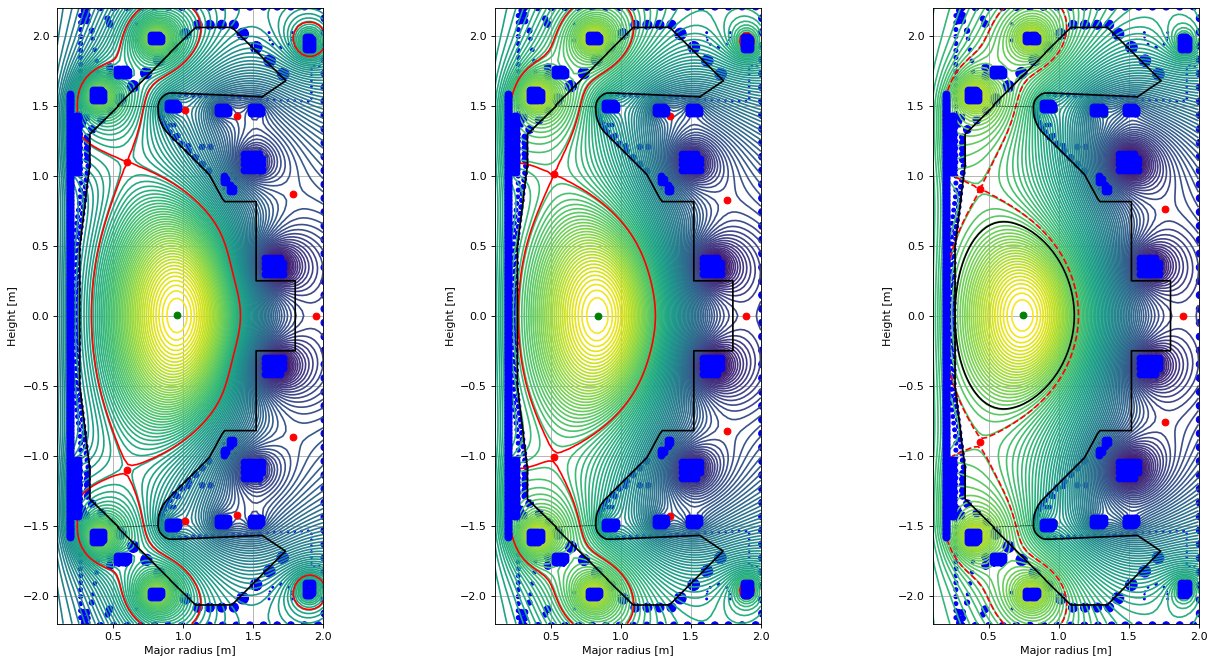

In [14]:
from copy import deepcopy
eq_forward_1 = deepcopy(eq)
eq_forward_2 = deepcopy(eq)

eq_forward_1.tokamak['P4'].current *= 1.5
GSStaticSolver.solve(eq=eq_forward_1, 
                     profiles=profiles, 
                     constrain=None, 
                     target_relative_tolerance=1e-9)

eq_forward_2.tokamak['P4'].current *= 1.5**2
GSStaticSolver.solve(eq=eq_forward_2, 
                     profiles=profiles, 
                     constrain=None, 
                     target_relative_tolerance=1e-9)


fig = plt.figure(figsize=(20, 10), dpi=80)
ax = fig.add_subplot(131)
ax.grid(True,which='both')
eq_forward.plot(axis=ax,show=False)
eq.tokamak.plot(axis=ax,show=False)
ax = fig.add_subplot(132)
ax.grid(True,which='both')
eq_forward_1.plot(axis=ax,show=False)
eq.tokamak.plot(axis=ax,show=False)
ax = fig.add_subplot(133)
ax.grid(True,which='both')
eq_forward_2.plot(axis=ax,show=False)
eq.tokamak.plot(axis=ax,show=False)


## 3. Limited Equilibrium
In this case, the plasma "touches" the limiter of the tokamak and is confined by the solid structures of the vessel. The LCFS is the farthest closed contour from the magnetic axis that just barely touches the wall.

In [ ]:
Rmin0=0.1 ; Rmax0=2.0 ; Zmin0=-2.2 ; Zmax0=2.2 ; NX=65 ; NY=129 ; 
p_a = 8.1e3 ; I_p=6.2e5 ; f_vac = 0.5 ; 
am0=1.8 ; an0=1.2;

In [ ]:

# Creates equilibrium object and initializes it with 
# a "good" solution
# plasma_psi = np.loadtxt('plasma_psi_example.txt')
eq = freegs.Equilibrium(tokamak=tokamak,
                        #domains can be changed 
                        Rmin=Rmin0, Rmax=Rmax0,    # Radial domain
                        Zmin=Zmin0, Zmax=Zmax0,   # Height range
                        #grid resolution can be changed
                        nx=NX, ny=NY, # Number of grid points
                        # psi=plasma_psi[::2,:])   
                        )



# Sets desired plasma properties for the 'starting equilibrium'
# Use one between ConstrainPaxisIp or ConstrainBetapIp
# values can be changed
# from freegsnke.jtor_update import ConstrainPaxisIp
profiles = ConstrainPaxisIp(eq, tokamak.limiter,
                            p_a, # Plasma pressure on axis [Pascals]
                            I_p, # Plasma current [Amps]
                            f_vac, # vacuum f = R*Bt
                            alpha_m = am0,
                            alpha_n = an0)
# from freegsnke.jtor_update import ConstrainBetapIp
# profiles = ConstrainBetapIp(eq, tokamak.limiter,
#                             betap, # betap proxy, 0.2 here
#                             I_p, # Plasma current [Amps]
#                             f_vac, # vacuum f = R*Bt
#                             alpha_m = 1.8,
#                             alpha_n = 1.2)

In [ ]:

# Sets some shape constraints (here very close to those used for initialization)
Rx = 0.45
Zx = 1.18

Rmid = 1.4   # Outboard midplane
Rin = 0.28  # Inboard midplane

xpoints = [(Rx, -Zx-.01),   # (R,Z) locations of X-points
           (Rx,  Zx)]
isoflux = [
           (Rx,Zx, Rx,-Zx),
           (Rmid, 0, Rin, 0.0),
           (Rmid,0, Rx,Zx),
           (Rmid,0, 1.2,.7),
           (Rmid,0, 1.2,-.7),
    
           # Link inner and outer midplane locations
           (Rx, Zx, .85, 1.7),
           (Rx, Zx, .75, 1.6),
           (Rx, Zx, Rin, 0.2),
           (Rx, Zx, Rin, 0.1),
           (Rx,-Zx, Rin, -0.1),
           (Rx,-Zx, Rin, -0.2),
           (Rx,-Zx, .85, -1.7),
           (Rx,-Zx, .75, -1.6),

           (Rx,-Zx, 0.45, -1.8),
           (Rx, Zx, 0.45,  1.8),
           ]


In [ ]:
eq.tokamak['P6'].current = 0
eq.tokamak['P6'].control = False
eq.tokamak['Solenoid'].control = False

constrain = freegs.control.constrain(xpoints=xpoints, 
                                     gamma=5e-6, 
                                     isoflux=isoflux
                                    )
constrain(eq)
                                    
from freegsnke import GSstaticsolver
NK = GSstaticsolver.NKGSsolver(eq)

Now we set the solenoid current to 40000 Amperes, in two stages to guide the constrained solver so that it still converges within some reasonable tolerance. With this example of machine and plasma configuration, due to the stray magnetic field of the solenoid, solenoid currents above $\approx$20000 Amperes result in solutions where the plasma is squeezed onto the central column.

In [ ]:
eq.tokamak['P6'].current = 0.1
eq.tokamak['P6'].control = False
eq.tokamak['Solenoid'].control = False
eq.tokamak['Solenoid'].current = 15000
# Nonlinear solve
freegs.solve(eq,          # The equilibrium to adjust
             profiles,    # The plasma profiles
             constrain,   # Plasma control constraints
             show=False,
             rtol=3e-3)

eq.tokamak['Solenoid'].current = 40000
freegs.solve(eq,          # The equilibrium to adjust
             profiles,    # The plasma profiles
             constrain,   # Plasma control constraints
             show=False,
             rtol=3e-3)

NK.solve(eq, profiles, target_relative_tolerance=1e-8)
fig = plt.figure(figsize=(5, 10), dpi=80);
ax = fig.add_subplot(111);
ax.grid(True,which='both');
eq.plot(axis=ax,show=False);
eq.tokamak.plot(axis=ax,show=False);
constrain.plot(axis=ax,show=False)

qprof = eq.q()
plt.figure()
plt.plot(qprof[0], qprof[1], '+')
plt.title('q profile')

Like we did for the diverted plasma, we save the coil currents to a pickle dictionary, which is used below to forward-solve the GS equilibrium from scratch, without starting with isoflux or X-point constraints.

In [ ]:
tcurrent_values={}
for coil in eq.tokamak.coils:
    tcurrent_values[coil[0]] = eq.tokamak[coil[0]].current

In [ ]:
import pickle
with open('simple_limited_currents_PaxisIp.pk', 'wb') as f:
    pickle.dump(obj=tcurrent_values,file=f)

### Forward-solve from scratch, for a limited plasma, with currents from dictionary
The following is very similar to the example above on the diverted plasma. If you want to only run the forward-solve, you should make sure that you have a suitable set of coil currents already saved somewhere.

In [ ]:
### Forward-solve from scratch, for a limited plasma, with currents from dictionary
# Forward-solve of an equilibrium

# Assign current values to the active poloidal field coils 
# corresponding to a diverted plasma. 
# This assigns the passive structure currents too, in this specific case these are all set to zero.
# Set initial equilibrium

# Assign current values to the active poloidal field coils 
# corresponding to a diverted plasma. 
# This assigns the passive structure currents too, in this specific case these are all set to zero.
import pickle
with open('simple_limited_currents_PaxisIp.pk', 'rb') as f:
    current_values = pickle.load(f)
for key in current_values.keys():
    eq.tokamak[key].current = current_values[key]

# Instantiate freeGSNKE static GS solver
from freegsnke import GSstaticsolver
# This requires use of the equilibrium itself to inform the solver of the domain and grid properties:
NK = GSstaticsolver.NKGSsolver(eq)
# Solve the forward GS problem corresponding to the tokamak metal currents set above and the requested profile properties
NK.solve(# The Equilibrium object sets the currents 
         eq, 
         # The profile sets the desired plasma properties
         profiles,
         # The relative tolerance set for convergence
         target_relative_tolerance=1e-8,
         verbose=1)

# Plot the equilibrium
# As in freeGS, the full black line is the tokamak.wall.
# In addition, the thin black dotted line shows the tokamak.limiter,
# i.e. the border of the region where the plasma is allowed to be.
# The limiter is passed to the equilibrium object by the profile object during the NK.solve call. 
fig = plt.figure(figsize=(5, 10), dpi=80)
ax = fig.add_subplot(111)
ax.grid(True,which='both')
eq.plot(axis=ax,show=False)
eq.tokamak.plot(axis=ax,show=False)

## 4. The same as above, but with "BetapIp" internal profile class
In the "BetapIp" profile class, instead of prescribing $p_a,$ we seek to match a proxy for the poloidal beta parameter, in particular the prefactors $\lambda$ and $\beta_0$ of the p' and f'f functions are adjusted to match a given value for $I_p$ and a given value of 
$$ \tilde{\beta}_p = \frac{8\pi}{\mu_0 I_p^2}   \int p(R,Z)\mathrm{d}R\mathrm{d}Z  $$ 
following Jeon (2015, arXiv:1503.03135). 

In [ ]:
# Create the machine.

# First, identify files containing the machine description.
# freeGSNKE requires the user to define the following environment variables 
# ACTIVE_COILS_PATH
# PASSIVE_COILS_PATH
# WALL_PATH
# LIMITER_PATH
# These define the machine geometry and properties.
import os
os.environ["ACTIVE_COILS_PATH"] = "../machine_configs/MAST-U/active_coils.pickle"
os.environ["PASSIVE_COILS_PATH"] = "../machine_configs/MAST-U/passive_coils.pickle"
os.environ["WALL_PATH"] = "../machine_configs/MAST-U/wall.pickle"
os.environ["LIMITER_PATH"] = "../machine_configs/MAST-U/limiter.pickle"

# Now the machine can actually be built:
from freegsnke import build_machine
tokamak = build_machine.tokamak()

### Diverted "BetapIp" equilibrium, inverse solve and forward solve

In [ ]:
Rmin0=0.1 ; Rmax0=2.0 ; Zmin0=-2.2 ; Zmax0=2.2 ; NX=65 ; NY=129 ; 
betap0 = 0.2 ; I_p=6.2e5 ; f_vac = 0.5 ; 
am0=1.8 ; an0=1.2;

In [ ]:

# Creates equilibrium object and initializes it with 
# a "good" solution
# plasma_psi = np.loadtxt('plasma_psi_example.txt')
eq = freegs.Equilibrium(tokamak=tokamak,
                        #domains can be changed 
                        Rmin=Rmin0, Rmax=Rmax0,    # Radial domain
                        Zmin=Zmin0, Zmax=Zmax0,   # Height range
                        #grid resolution can be changed
                        nx=NX, ny=NY, # Number of grid points
                        # psi=plasma_psi[::2,:])   
                        )

# Sets desired plasma properties for the 'starting equilibrium'
# Use one between ConstrainPaxisIp or ConstrainBetapIp
# values can be changed
# from freegsnke.jtor_update import ConstrainPaxisIp
# profiles = ConstrainPaxisIp(eq, tokamak.limiter,
#                             p_a, # Plasma pressure on axis [Pascals]
#                             I_p, # Plasma current [Amps]
#                             f_vac, # vacuum f = R*Bt
#                             alpha_m = am0,
#                             alpha_n = an0)
from freegsnke.jtor_update import ConstrainBetapIp
profiles = ConstrainBetapIp(eq, tokamak.limiter,
                            betap0, # betap proxy
                            I_p, # Plasma current [Amps]
                            f_vac, # vacuum f = R*Bt
                            alpha_m = 1.8,
                            alpha_n = 1.2)

In [ ]:

# Sets some shape constraints (here very close to those used for initialization)
Rx = 0.6
Zx = 1.1

Rmid = 1.41   # Outboard midplane
Rin = 0.36  # Inboard midplane

xpoints = [(Rx, -Zx-.01),   # (R,Z) locations of X-points
           (Rx,  Zx)]
isoflux = [
           (Rx,Zx, Rx,-Zx),
           (Rmid, 0, Rin, 0.0),
           (Rmid,0, Rx,Zx),
           (Rmid,0, 1.2,.7),
           (Rmid,0, 1.2,-.7),
    
           # Link inner and outer midplane locations
           (Rx, Zx, .85, 1.7),
           (Rx, Zx, .75, 1.6),
           (Rx, Zx, Rin, 0.2),
           (Rx, Zx, Rin, 0.1),
           (Rx,-Zx, Rin, -0.1),
           (Rx,-Zx, Rin, -0.2),
           (Rx,-Zx, .85, -1.7),
           (Rx,-Zx, .75, -1.6),

           (Rx,-Zx, 0.45, -1.8),
           (Rx, Zx, 0.45,  1.8),
           ]

eq.tokamak['P6'].current = 0
eq.tokamak['P6'].control = False
eq.tokamak['Solenoid'].control = False

constrain = freegs.control.constrain(xpoints=xpoints, 
                                     gamma=5e-6, 
                                     isoflux=isoflux
                                    )
constrain(eq)

In [ ]:
from freegsnke import GSstaticsolver
NK = GSstaticsolver.NKGSsolver(eq)

In [ ]:
eq.tokamak['P6'].current = 0
eq.tokamak['P6'].control = False
eq.tokamak['Solenoid'].control = False
eq.tokamak['Solenoid'].current = 15000
# Nonlinear solve
freegs.solve(eq,          # The equilibrium to adjust
             profiles,    # The plasma profiles
             constrain,   # Plasma control constraints
             show=False,
             rtol=3e-3)
# eq.tokamak['Solenoid'].current = 40000
# freegs.solve(eq,          # The equilibrium to adjust
#              profiles,    # The plasma profiles
#              constrain,   # Plasma control constraints
#              show=False,
#              rtol=3e-3)
             
NK.solve(eq, profiles, target_relative_tolerance=1e-8)
fig = plt.figure(figsize=(5, 10), dpi=80);
ax = fig.add_subplot(111);
ax.grid(True,which='both');
eq.plot(axis=ax,show=False);
eq.tokamak.plot(axis=ax,show=False);
constrain.plot(axis=ax,show=False)

qprof = eq.q()
plt.figure()
plt.plot(qprof[0], qprof[1], '+')
plt.title('q profile')

In [ ]:
tcurrent_values={}
for coil in eq.tokamak.coils:
    tcurrent_values[coil[0]] = eq.tokamak[coil[0]].current

import pickle
with open('simple_diverted_currents_BetapIp.pk', 'wb') as f:
    pickle.dump(obj=tcurrent_values,file=f)

### Diverted "BetapIp", forward-solve from scratch with coil currents from file dict

In [ ]:
# Forward-solve of an equilibrium

# Assign current values to the active poloidal field coils 
# corresponding to a diverted plasma. 
# This assigns the passive structure currents too, in this specific case these are all set to zero.
# Set initial equilibrium

# Assign current values to the active poloidal field coils 
# corresponding to a diverted plasma. 
# This assigns the passive structure currents too, in this specific case these are all set to zero.
import pickle
with open('simple_diverted_currents_BetapIp.pk', 'rb') as f:
    current_values = pickle.load(f)
for key in current_values.keys():
    eq.tokamak[key].current = current_values[key]

# Instantiate freeGSNKE static GS solver
from freegsnke import GSstaticsolver
# This requires use of the equilibrium itself to inform the solver of the domain and grid properties:
NK = GSstaticsolver.NKGSsolver(eq)
# Solve the forward GS problem corresponding to the tokamak metal currents set above and the requested profile properties
NK.solve(# The Equilibrium object sets the currents 
         eq, 
         # The profile sets the desired plasma properties
         profiles,
         # The relative tolerance set for convergence
         target_relative_tolerance=1e-8,
         verbose=1)

# Plot the equilibrium
# As in freeGS, the full black line is the tokamak.wall.
# In addition, the thin black dotted line shows the tokamak.limiter,
# i.e. the border of the region where the plasma is allowed to be.
# The limiter is passed to the equilibrium object by the profile object during the NK.solve call. 
fig = plt.figure(figsize=(5, 10), dpi=80)
ax = fig.add_subplot(111)
ax.grid(True,which='both')
eq.plot(axis=ax,show=False)
eq.tokamak.plot(axis=ax,show=False)